# CORDIC 
   cordic算法针对于单片机和FPGA等计算能力弱的嵌入式设备对计算三角函数（sin、cos、tan），甚至双曲线、指数、对数这样复杂的函数能力不足所提出的一种算法，对于这些复横congzuobiaozhi杂计算通常采用查表法和泰勒级数逼近的方法。而cordic算法就是计算正弦余弦方法的一种。而对所需角度的正余弦计算可以转换为求取目标角度与单位圆交点的横纵坐标值。
   将目标角度分成多个小角度之和，交点的横纵坐标等于多个小角度的方向变换矩阵的乘积与原点坐标相乘，同时方向矩阵中元素可以利用移位操作表示，这样目标角度的正余弦就可以用矩阵乘积表示。

In [42]:
from pynq import Overlay
from pynq import MMIO
import numpy as np
import struct
import binascii
import cmath
import random
import matplotlib.pyplot as plt

NUM_SAMPLES = 50

In [43]:
ol=Overlay('../cor/overlay/cordic.bit') #Change name of bitstream as required

# 设置初始地址与大小

In [44]:
cordic_ip=MMIO(0x43C00000,10000) #Change base address as required

# 设置数组记录

In [45]:
r_error=np.zeros(NUM_SAMPLES)
theta_error=np.zeros(NUM_SAMPLES)
ind=np.arange(NUM_SAMPLES)
r_rmse=np.zeros(NUM_SAMPLES)
theta_rmse=np.zeros(NUM_SAMPLES)

# Hardware Design
随机设置需要计算点的横纵坐标，计算点的极坐标系，将x、y写入cordic_ip中开启IP计算极坐标。

In [46]:
for i in range(NUM_SAMPLES):
    #Generating random inputs
    x=random.uniform(-1,1)
    y=random.uniform(-1,1)
    
    #Computing golden output
    cn=complex(x,y)
    cn=cmath.polar(cn)
    
    #Converting input to bytes to be sent to FPGA
    x=(struct.unpack('<I', struct.pack('<f', x))[0])
    y=(struct.unpack('<I', struct.pack('<f', y))[0])
    
    #Writing values to the FPGA
    cordic_ip.write(0x10,x)                             #Change the offset as mentioned in vivado file
    cordic_ip.write(0x18,y)                             #Change the offset as mentioned in vivado file
    
    #Starting and stopping the IP (Don't change this)
    cordic_ip.write(0x00,1)
    cordic_ip.write(0x00,0)
    
    #Reading from IP
    r=hex(cordic_ip.read(0x20))                         #Change the offset as mentioned in vivado file
    r=r[2:]
    theta=hex(cordic_ip.read(0x30))                     #Change the offset as mentioned in vivado file
    theta=theta[2:]
    
    #Converting to float
    if r!=0:
        r=struct.unpack('>f', binascii.unhexlify(r))
        r=r[0]
    if theta!=0:
        theta=struct.unpack('>f', binascii.unhexlify(theta))
        theta=theta[0]
        
    #Comparing with golden output    
    r_error[i]="{0:.8f}".format(abs(r-cn[0]))
    theta_error[i]="{0:.8f}".format(abs(theta-cn[1]))

## 确定精准度

In [47]:
sum_sq_r=0
sum_sq_theta=0
for i in range(NUM_SAMPLES):
    sum_sq_r =sum_sq_r+(r_error[i]*r_error[i])
    r_rmse = np.sqrt(sum_sq_r / (i+1))
    sum_sq_theta =sum_sq_theta+(theta_error[i]*theta_error[i])
    theta_rmse = np.sqrt(sum_sq_theta / (i+1))
print("Radius RMSE: ", r_rmse, "Theta RMSE:", theta_rmse)    
if r_rmse<0.001 and theta_rmse<0.001:
    print("PASS")
else:
    print("FAIL")

Radius RMSE:  7.477967638335968e-08 Theta RMSE: 1.7129275991704966e-05
PASS


## 分别显示50次数据的误差

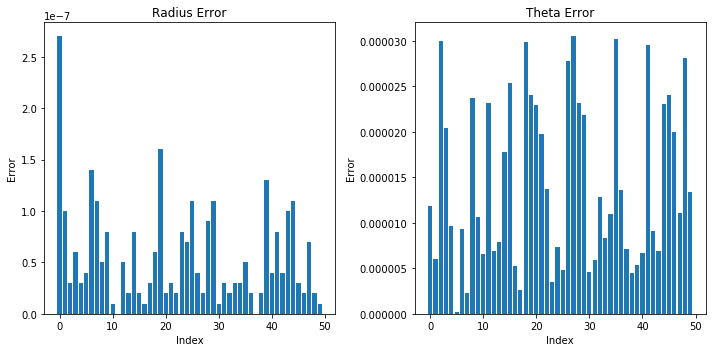

In [48]:
plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
plt.bar(ind,r_error)
plt.title("Radius Error")
plt.xlabel("Index")
plt.ylabel("Error")
#plt.xticks(ind)
plt.tight_layout()

plt.subplot(1,2,2)
plt.bar(ind,theta_error)
plt.title("Theta Error")
plt.xlabel("Index")
plt.ylabel("Error")
#plt.xticks(ind)
plt.tight_layout()